### Probability of Employee Leaving | Predictions with Keras/TensorFlow
- [Link](https://www.digitalocean.com/community/tutorials/how-to-build-a-deep-learning-model-to-predict-employee-retention-using-keras-and-tensorflow)

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
import shap
from sklearn.metrics import confusion_matrix

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/kerasDO/master/HR_comma_sep.csv")

print('\nDataframe Shape: ', {df.shape})
df.info()


Dataframe Shape:  {(14999, 10)}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<AxesSubplot:>

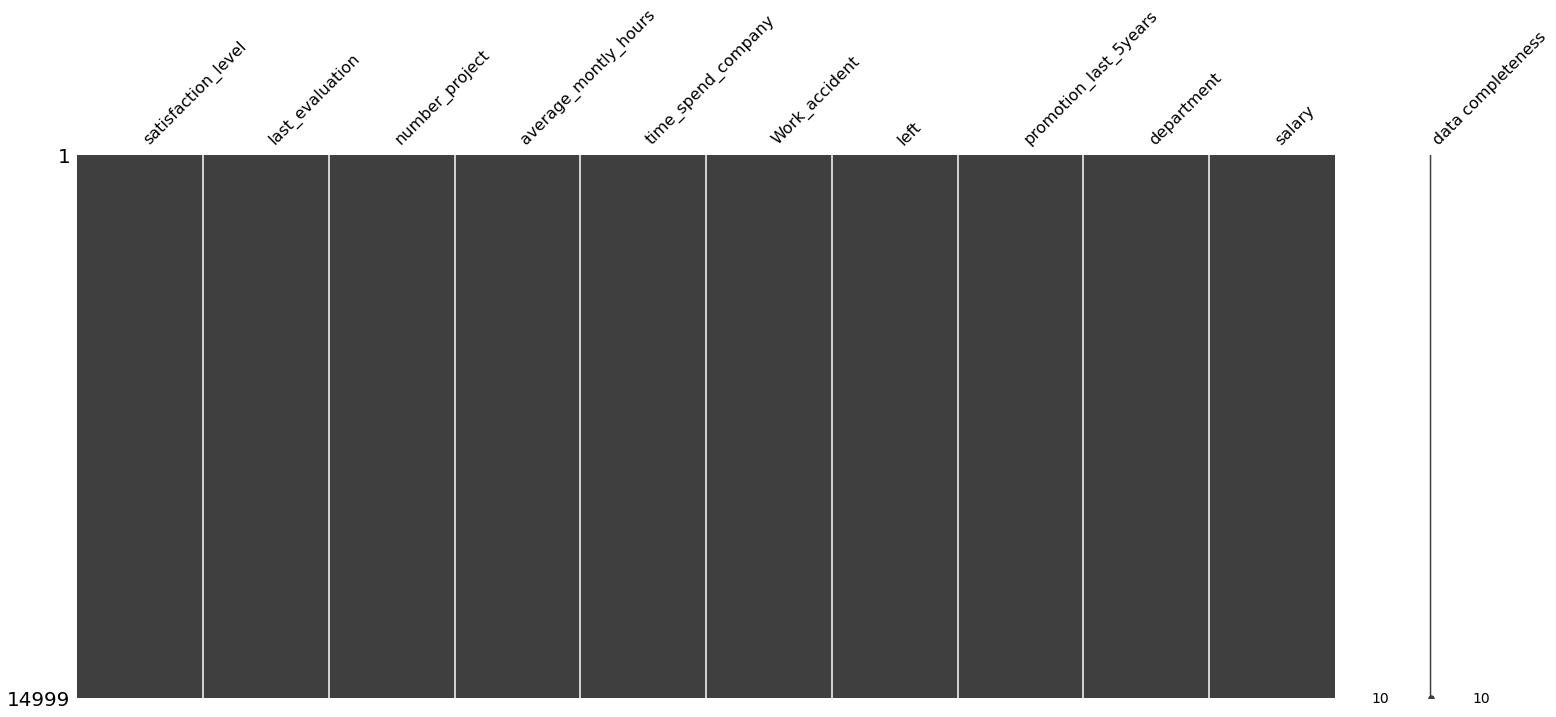

In [18]:
msno.matrix(df, labels=True, sort="descending")

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [44]:
df.value_counts('left')

left
0    11428
1     3571
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [21]:
feats = ['department','salary']
# feats_2 = df.select_dtypes(include = ['object'])
df_final = pd.get_dummies(df, columns = feats, drop_first=True)

In [22]:
X = df_final.drop(['left'],axis=1).values
y = df_final['left'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
classifier = Sequential()
classifier.add(Dense(9, kernel_initializer = "uniform",activation = "relu", input_dim=18))
classifier.add(Dense(3, kernel_initializer = "uniform",activation = "relu", input_dim=18))
classifier.add(Dense(1, kernel_initializer = "uniform",activation = "sigmoid"))
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 5)

Epoch 1/5
1200/1200 [==============================] - 6s 4ms/step - loss: 0.3931 - accuracy: 0.8137
Epoch 2/5
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2079 - accuracy: 0.9387
Epoch 3/5
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1752 - accuracy: 0.9505
Epoch 4/5
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1650 - accuracy: 0.9535
Epoch 5/5
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1588 - accuracy: 0.9531


In [35]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 9)                 171       
                                                                 
 dense_7 (Dense)             (None, 3)                 30        
                                                                 
 dense_8 (Dense)             (None, 1)                 4         
                                                                 
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


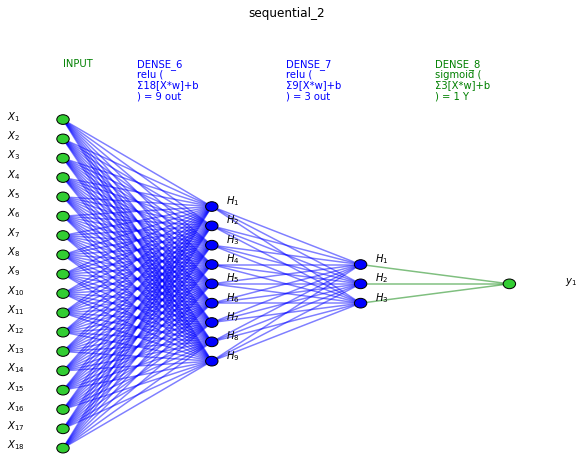

In [36]:
# Extract info for each layer in a keras model.
def utils_nn_config(classifier):
    lst_layers = []
    if "Sequential" in str(classifier): #-> Sequential doesn't show the input layer
        layer = classifier.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in classifier.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers


# Plot the structure of a keras neural network.
def visualize_nn(classifier, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(classifier)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=classifier.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

visualize_nn(classifier, description=True, figsize=(10,8))

# utils.plot_model(classifier, to_file='classifier.png', show_shapes=True, show_layer_names=True)

In [37]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
cm

array([[2234,   65],
       [  56,  645]], dtype=int64)

In [40]:

dt_pred = classifier.predict(X)
# dt_pred = (dt_pred > 0.5)
df['nueral_predictions'] = dt_pred

def dt_predictions(a):
    if a['nueral_predictions'] == True:
        return 'YES'
    elif a['nueral_predictions'] == False:
        return 'NO'
    else:
        return 'ERROR'

df['High_Probability_to_Leave'] = df.apply(dt_predictions, axis = 1)

In [41]:
df.value_counts('High_Probability_to_Leave')

High_Probability_to_Leave
YES    14999
dtype: int64

In [42]:
df.tail()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,nueral_predictions,High_Probability_to_Leave
14994,0.40,0.57,2,151,3,0,1,0,support,low,1.0,YES
14995,0.37,0.48,2,160,3,0,1,0,support,low,1.0,YES
14996,0.37,0.53,2,143,3,0,1,0,support,low,1.0,YES
14997,0.11,0.96,6,280,4,0,1,0,support,low,1.0,YES
14998,0.37,0.52,2,158,3,0,1,0,support,low,1.0,YES


In [43]:
df.to_excel(r'C:\Data Sciences\Data\outputs\df_pred.xlsx')